## loadimage for python

In [2]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import inf

# useless (need to download CULA which is not available anymore)
# import pycuda.autoinit
# import pycuda.gpuarray as gpuarray
# import skcuda.linalg as linalg

import os
from scipy.misc import imread

def loadimage(individual, condition):
    imgroot='images';
    image = None
    if individual in [1, 2, 3]:
        conditionList=['A+000E+00',
                        'A+000E+45',
                        'A+000E-35',
                        'A-035E+15',
                        'A+035E+15',
                        'A+020E+10',
                        'A-025E+00',
                        'A-015E+20',
                        'A+035E-20',
                        'A+050E+00']
        image = imread(os.path.join(imgroot, 'yaleB%02d' % (individual), 'yaleB%02d_P00' % (individual) + conditionList[condition-1] + '.pgm'), mode='L')
    elif individual == 4:
        image = imread(os.path.join(imgroot, 'outliers', 'outlier%d' %(condition-1) + '.pgm'), mode='L')
    return image

## 1 Low Rank Matrix Completion (LRMC)

In [43]:
def shrinked_thresholding(X, tau):
    return np.sign(X) * np.maximum(np.absolute(X)-tau,0)


def mse(T, R, W):
    """
    T: grayscale Matrix representing the true non altered image
    R: grayscale Matrix representing the recovered image using lrmc
    return: mean-squared-error between T and R on the unobserved entries
    """
    return np.sum(((T-R) * (1-W)) **2)/ np.sum(1-W)


def lrmc(X, W, tau, beta, max_iter=20000):
    Z = np.zeros_like(X)
    A = np.zeros_like(X)
    
    i = 0
    while i < max_iter:
        # evaluate the norm2 error between A and X on the unobserved data: (1-W)
        #fro_prev = mse(X, A, W)
        
        #print('beta, %f Iteration number: %d || error  = %f \n' % (beta, i, fro_prev))
        U, S, V =  np.linalg.svd(Z * W, full_matrices=False)
        
        S = shrinked_thresholding(np.diag(S), tau)
        
        A = U.dot(S.dot(V))
        
        Z_next = Z + beta * (W * (X - A))
        
        # decay learning rate try
        #fro = mse(X, A, W)        
        #if (fro > fro_prev):
        #    beta *= 0.9
        
        # preferably use relative error
        if np.linalg.norm(Z_next - Z, inf) < 1e-2:
            break
            
        Z = Z_next
        i += 1
        
    return A

## 2 Face Completion

## Acting on an individual face (bad)

175.568142337


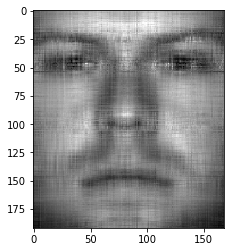

In [23]:
X = loadimage(1,1)
plt.imshow(X, cmap='gray')
W = np.random.binomial(1, 1-0.8, X.shape) # 0.2 missing data = 1 - 0.2
plt.imshow(np.array(X * W, dtype='u1'), cmap='gray')

D, N = X.shape

M = np.sum(W)
beta = min(2, D * N / M)
A = lrmc(X, W, 4e5, beta)

plt.imshow(A, cmap='gray')
print(mse(X, A, W))

## Method1: X = ($192 \times 168$, $10$)

This is the correct method as detailed in the report. Yet as we are dealing with only 10 images of faces of dimension ($192 \times 168$) it leads to poor result. One way to do it is to consider all the $65$ faces of a dataset and to apply the lrmc algorithm on the matrix $X$ of size ($192 \times 168$, $65$). This is what is done it method 3 for the 2 dataset.

In [26]:
def preprocess(individual, percent, nfaces=10):
    temp = loadimage(individual,1)
    D, N = temp.shape
    
    X = np.zeros((D*N, nfaces))
    
    for i in range(nfaces):
        X[:, i] = loadimage(1,i).flatten()
        
    W = np.random.binomial(1, 1-percent, X.shape)
    
    return X, W, D, N

In [27]:
def plotFaces(X, W, D, N, percent, taus=None, nfaces=10):
    taus = [1e3, 2*1e4, 4*1e5, 8*1e6] if taus is None else taus

    c, l = nfaces, len(taus)
    f, ax = plt.subplots(l+1, c, figsize=(25, l*4))

    mse_list = []
    
    for i in range(nfaces):
        ax[0, i].imshow(X[:,i].reshape(D, N), cmap='gray')
        ax[0, 5].set_title("Real Faces", size=11)
        ax[0, i].axis('off')

    for i in range(nfaces):
        ax[0, i].imshow((X[:,i] * W[:,i]).reshape(D, N), cmap='gray')
        ax[0, i].set_title("missing entries : %d %%" % (percent * 100), size=9)
        ax[0, i].axis('off')

    R, C = X.shape    

    for ix1, tau in enumerate(taus, 1):
        beta = min(2,  R*C / np.sum(W))
        A = lrmc(X, W, tau, beta)
        
        ## add mse for a special tau value
        mse_list.append(mse(X, A, W))
        
        for i in range(nfaces):
            ax[ix1, i].axis('off')
            ax[ix1, i].imshow(A[:,i].reshape(D, N), cmap='gray')
            ax[ix1, 5].set_title('Tau = %.1e' % tau)
    
    return np.array(mse_list)

103.679882812


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in double_scalars


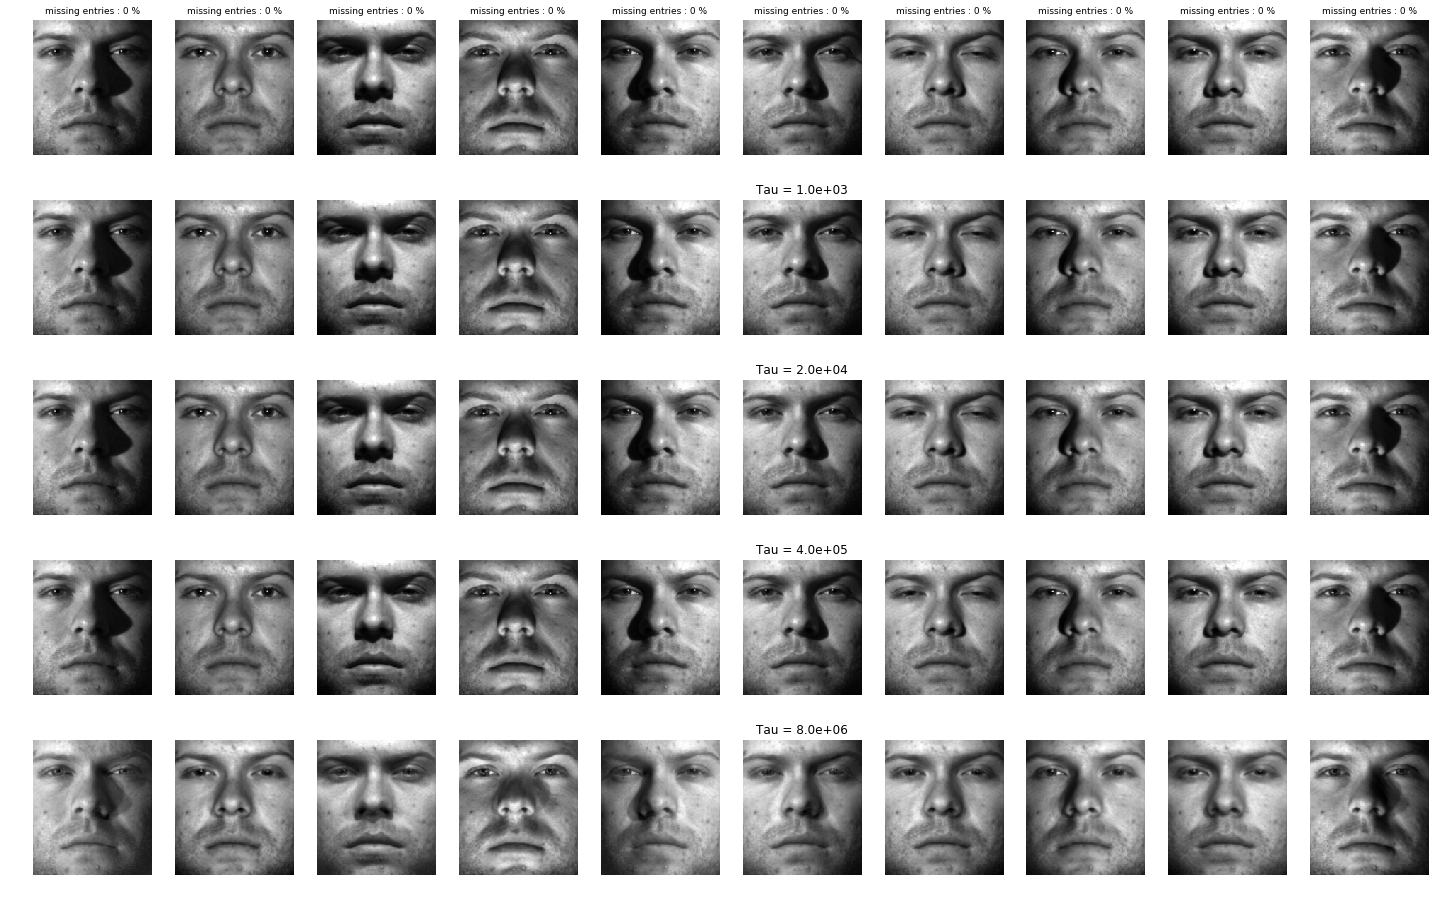

In [16]:
percent = 0
taus = [1e3, 2*1e4, 4*1e5, 8*1e6]

X, W, D, N = preprocess(1, percent=percent)
mse_0 = plotFaces(X, W, D, N, percent, taus)

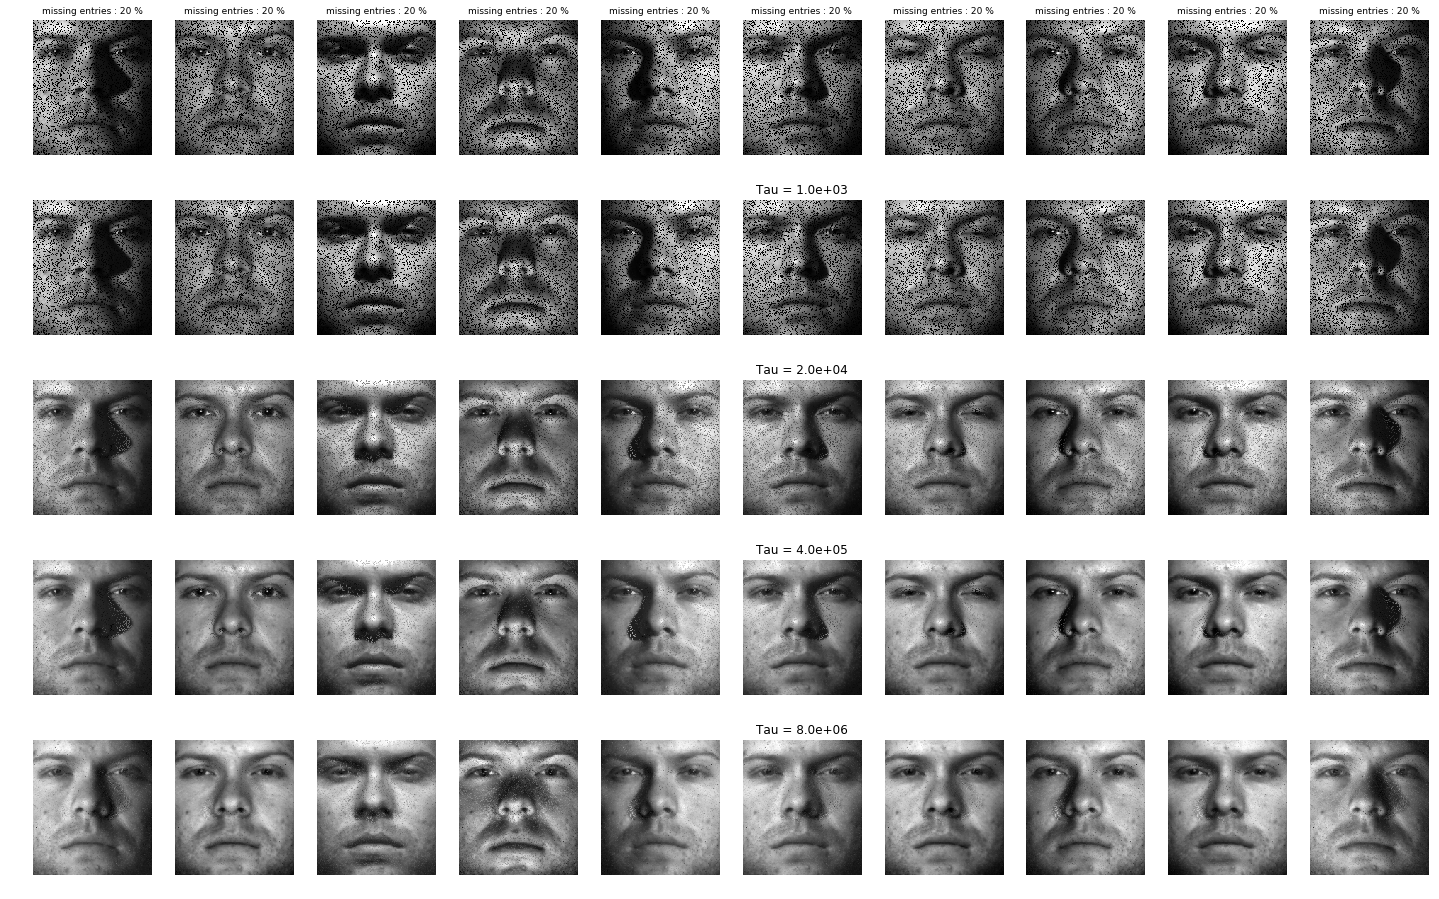

In [116]:
percent = 0.2
taus = [1e3, 2*1e4, 4*1e5, 8*1e6]

X_20, W_20, D_20, N_20 = preprocess(1, percent=percent)
mse_20 = plotFaces(X_20, W_20, D_20, N_20, percent, taus)

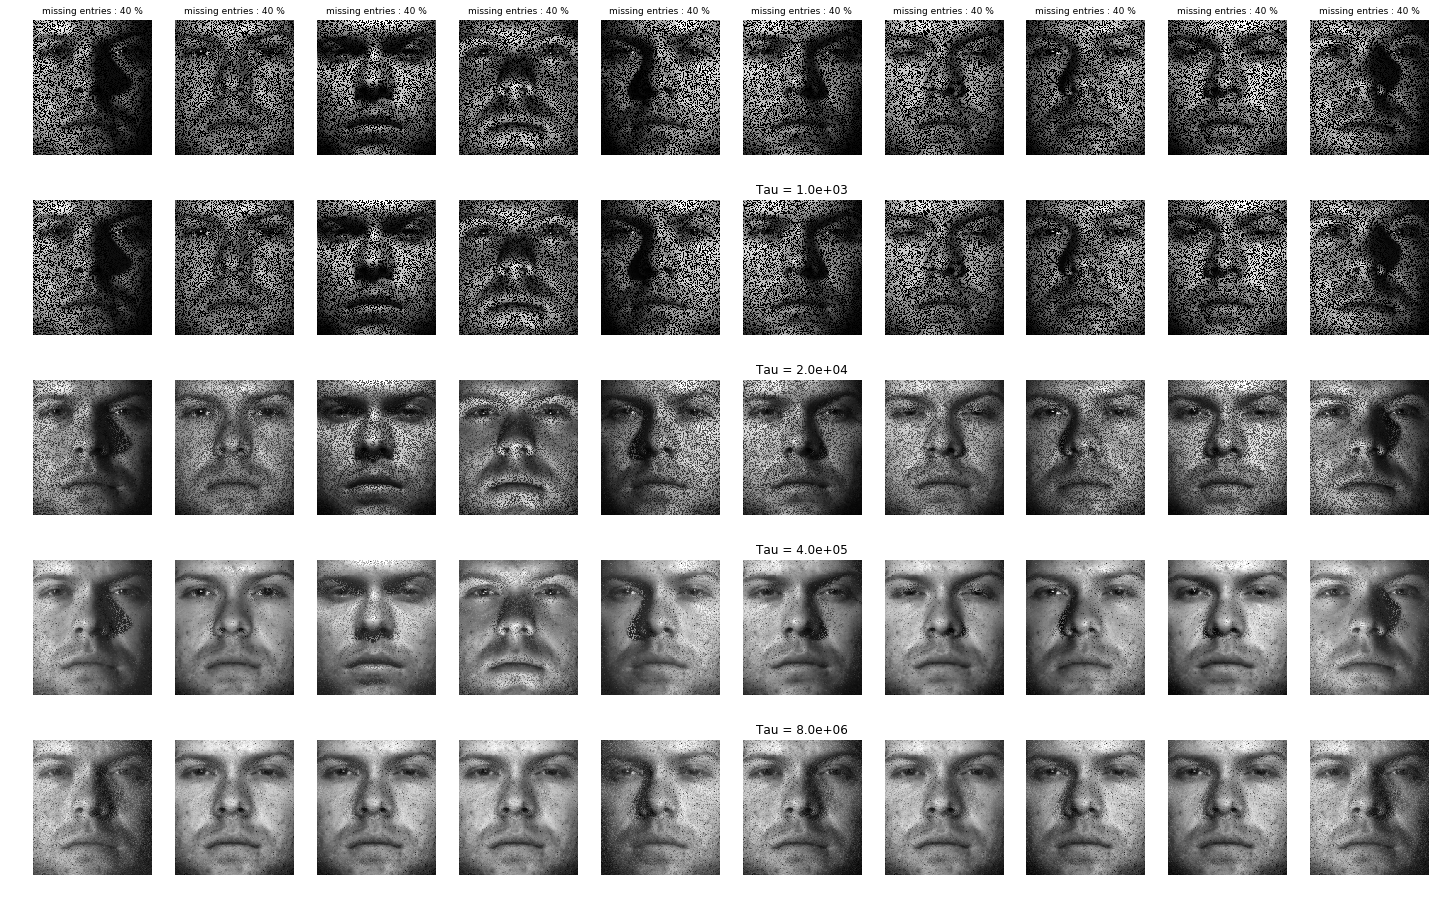

In [290]:
percent = 0.4
taus = [1e3, 2*1e4, 4*1e5, 8*1e6]

X_40, W_40, D_40, N_40 = preprocess(1, percent=percent)
mse_40 = plotFaces(X_40, W_40, D_40, N_40, percent, taus)

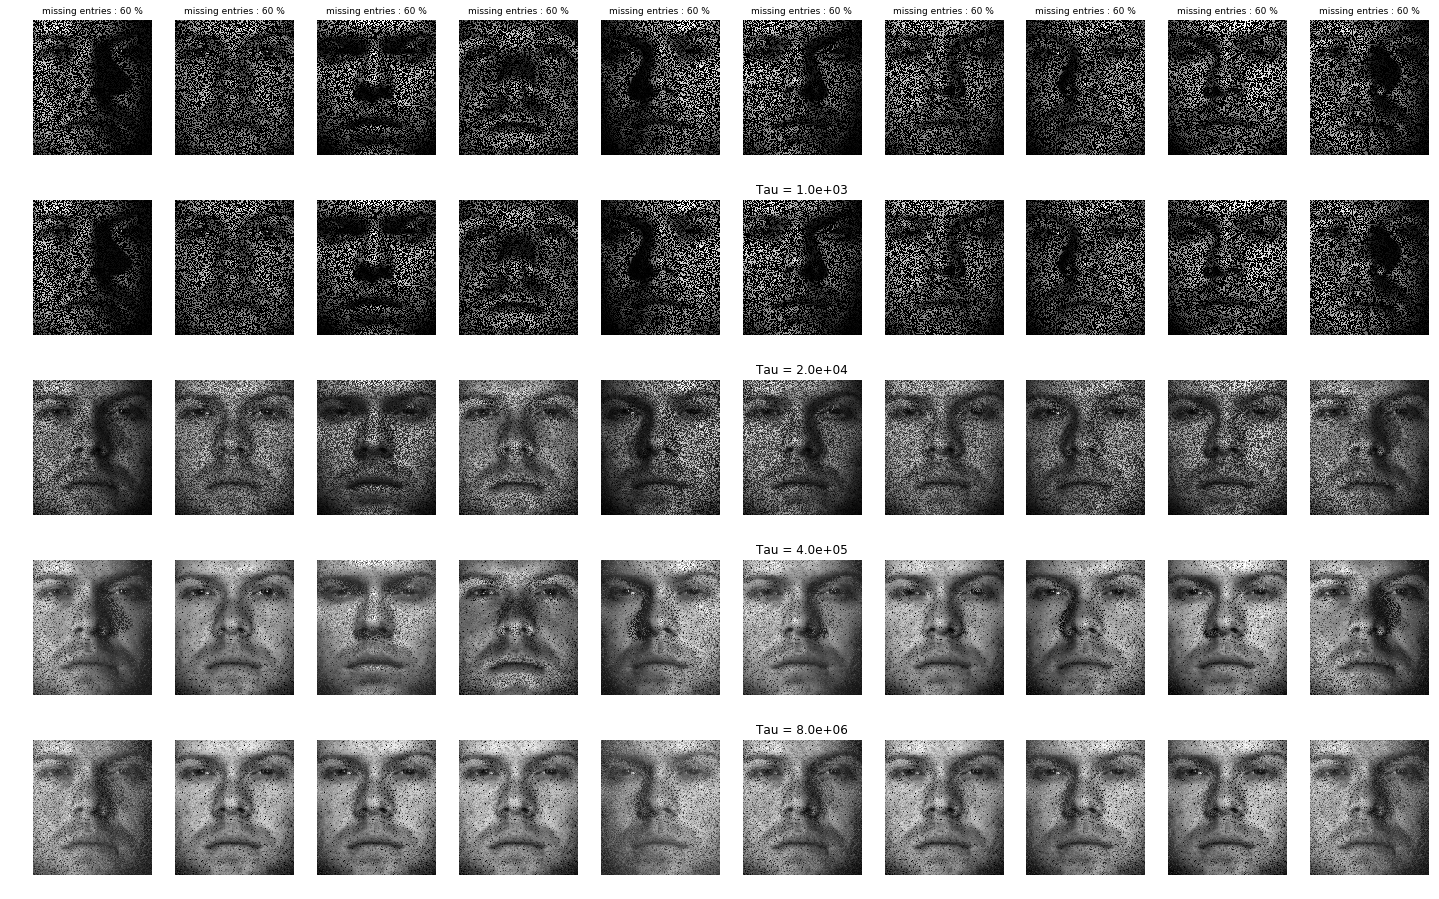

In [291]:
percent = 0.6
taus = [1e3, 2*1e4, 4*1e5, 8*1e6]

X_60, W_60, D_60, N_60 = preprocess(1, percent=percent)
mse_60 = plotFaces(X_60, W_60, D_60, N_60, percent, taus)

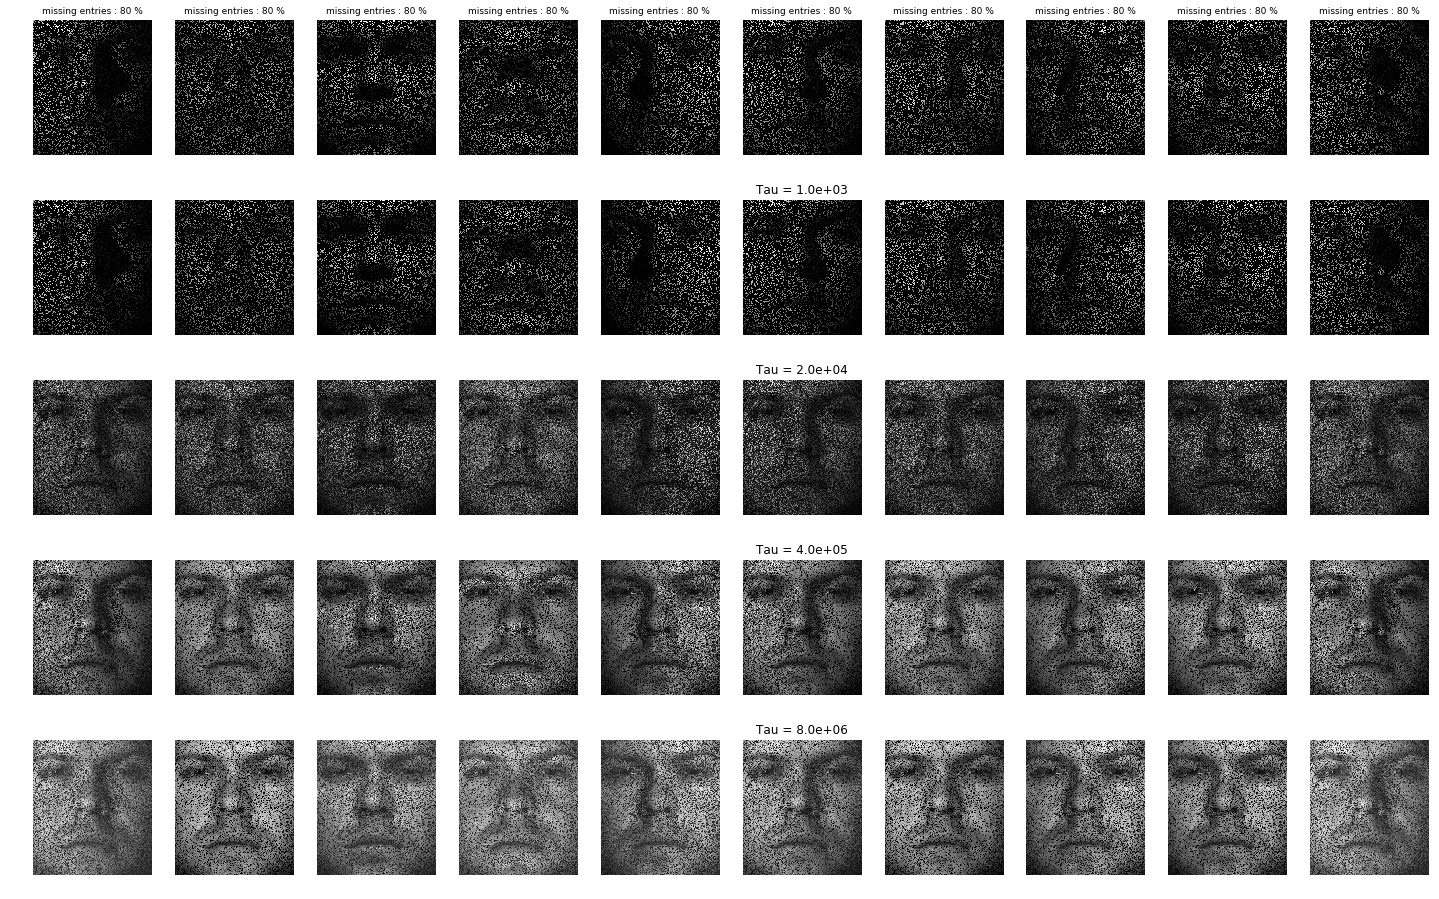

In [28]:
percent = 0.8
taus = [1e3, 2*1e4, 4*1e5, 8*1e6]

X_80, W_80, D_80, N_80 = preprocess(1, percent=percent)
mse_80 = plotFaces(X_80, W_80, D_80, N_80, percent, taus)

0 %          20 %          40 %          60 %          80 %        tau
0  NaN  12018.850921  12635.345789  13016.558687  13292.280993     1000.0
1  NaN   1394.644859   3675.454970   6727.078529  10086.782159    20000.0
2  NaN    316.427326    598.173535   1507.202526   4312.829519   400000.0
3  NaN    679.561238    907.870875   1597.000648   4287.706176  8000000.0

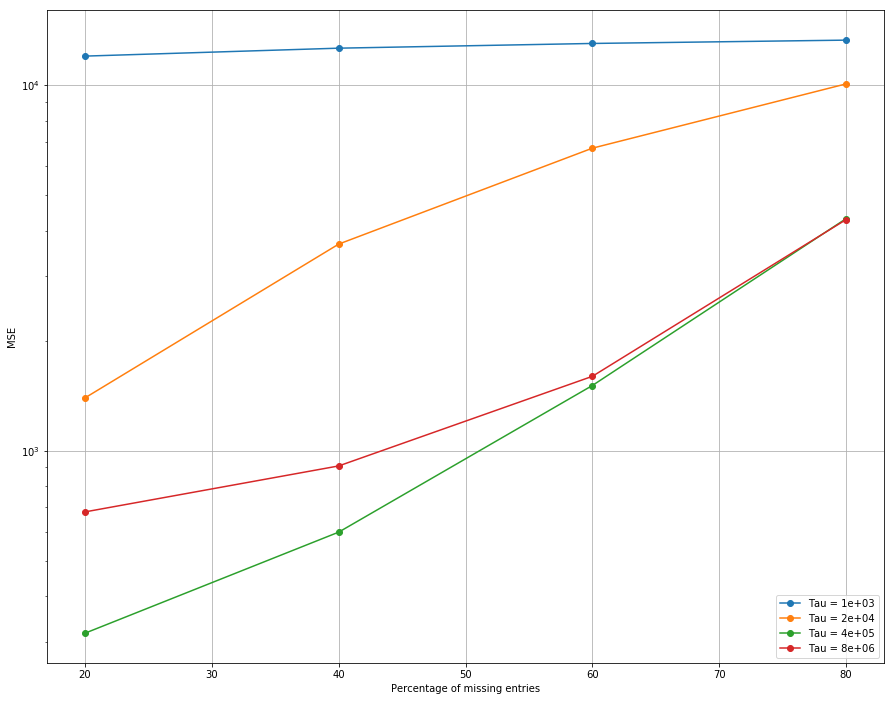

In [319]:
import pandas as pd

mse_total = np.array([mse_0, mse_20, mse_40, mse_60, mse_80]).T
taus = [1e3, 2*1e4, 4*1e5, 8*1e6]
plt.figure(figsize=(15,12))
for i in range(len(mse_total)):
    plt.plot([0, 20, 40, 60, 80], mse_total[i], 'o-', label="Tau = %.0e" % taus[i])

plt.yscale("log")
plt.ylabel("MSE")
plt.xlabel("Percentage of missing entries")
plt.grid(True)
plt.legend()


df = pd.DataFrame(mse_total, columns=['0 %', '20 %', '40 %', '60 %', '80 %'])
df['tau'] = taus
df

## Method 3: $X$ = ($96 \times 84$, $64$)

In [120]:
import glob

def preprocess3(imgroot, individual):    
    if individual in [1, 2, 3, 20]:
        root = os.path.join(imgroot, 'yaleB%02d_reduced' % (individual))
        img_list = glob.glob(os.path.join(root, "*.pgm"))
        
        D, N = imread(img_list[0]).shape
        X = np.zeros((D * N, len(img_list[:-1])))
        
        for i, img in enumerate(img_list[:-1]):
            X[:, i] = imread(img).flatten()
            
    return X

In [122]:
def plot(X, percents, taus, face):
    l, t = len(percents), len(taus);
    
    if face > X.shape[1] or face < 0:
        print('Incorrect face number to display !')
        return
    
    
    f, ax = plt.subplots(len(taus)+1, len(percents), figsize=(12, t*4))
    f.subplots_adjust(wspace=0.1, hspace=0)
    
    # initialize W for each percents
    W = np.zeros( X.shape + (l,) )
    for j, p in enumerate(percents):
        W[:, :, j] = np.random.binomial(1, 1-p, X.shape)
    
    # display corrupted images
    for j, p in enumerate(percents):
        ax[0, j].axis('off')
        ax[0, j].imshow( (W[:, :, j] * X)[:, face].reshape(96, 84), cmap='gray')
        ax[0, j].set_title('Missing entries: %d %%' % (p*100), size=8)
    
    for i, tau in enumerate(taus, 1):
        for j, p in enumerate(percents):
            
            # initialize beta
            beta = min(2,  X.size / np.sum(W[:, :, j]))
            
            A = lrmc(X, W[:, :, j], tau, beta, 1000)
            
            ax[i, j].axis('off')
            ax[i, j].imshow(A[:, face].reshape(96, 84), cmap='gray')
            ax[i, j].set_title('MSE: %.2f' % mse(A, X, W[:, :, j]))

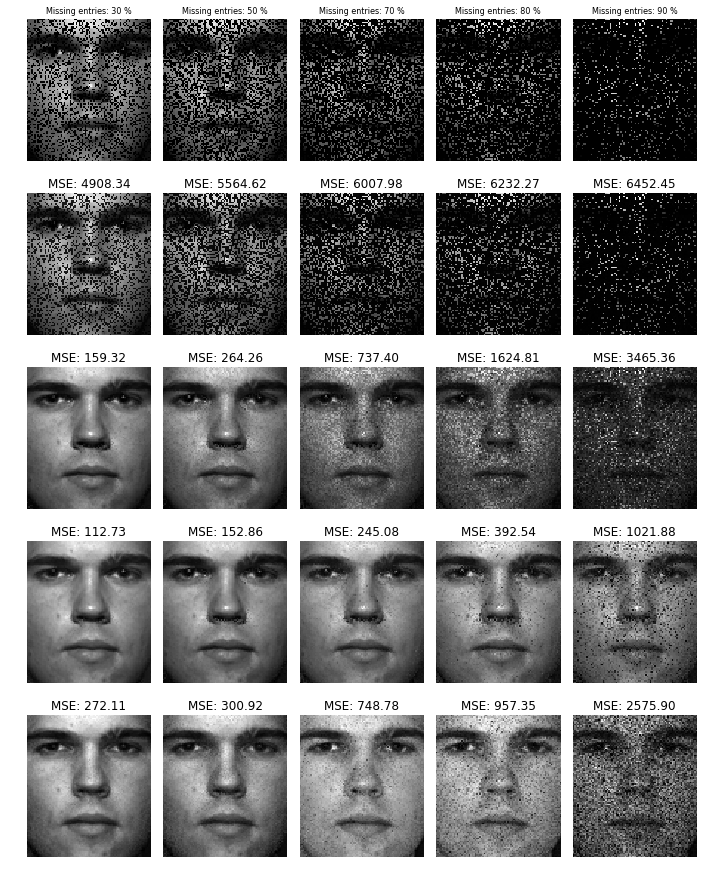

In [123]:
percents = [0.3, 0.5, 0.7, 0.8, 0.9]
taus = [1e3, 2*1e4, 4*1e5, 8*1e6]

X = preprocess3('images_reduced', 20) # 20th person load all 64 images
plot(X, percents, taus, 1) # display only first position (frontal image)

## Method 4: Reinjection

As developped p77 of _Generalized Principal Component Analysis_, one can repeat the lrmc algorithm with an increasing sequence of $\tau$'s and at each run, initialize A with the value previously obtained. This will actually solve the following problem:

$$
\min_{A} \quad ||A||_{*} \quad s.t \quad \mathcal{P}_{\Omega}(A) = \mathcal{P}_{\Omega}(X)
$$

This is what I've implemented in this section

In [19]:
def lrmc_tau(X, W, taus, beta, max_iter=1000):
    
    def lrmc(X, W, tau, beta, A, Z, max_iter=1000):
        A = np.zeros_like(X) if A is None else A
        Z = np.zeros_like(X) if Z is None else Z
        
        i = 0
        while i < max_iter:
            U, S, V =  np.linalg.svd(Z * W, full_matrices=False)

            S = shrinked_thresholding(np.diag(S), tau)

            A = U.dot(S.dot(V))

            Z_next = Z + beta * (W * (X - A))

            if np.linalg.norm(Z_next - Z, inf) < 1e-2:
                break

            Z = Z_next
            i += 1
        return A, Z
    
    A = None
    Z = None
    for i, tau in enumerate(taus):
        A, Z = lrmc(X, W, tau, beta, A, Z, max_iter=max_iter)
    return A

194.41708402


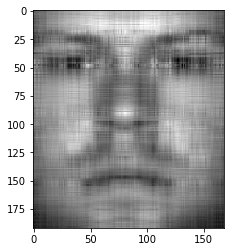

In [24]:
# test only on a single image
X = loadimage(1,1)
plt.imshow(X, cmap='gray')
W = np.random.binomial(1, 1-0.8, X.shape) # 0.8 missing data = 1 - 0.8

D, N = X.shape

M = np.sum(W)
beta = min(2, D * N / M)
A = lrmc_tau(X, W, [1e3, 2e4, 4e5], beta)

plt.imshow(A, cmap='gray')
print(mse(X, A, W))

## 3 Movie Recommendation Grand Challenge

In [3]:
X_horror = np.load('horror_mat.npy')
X_romance = np.load('romance_mat.npy')
X_horror_romance = np.load('horror_romance_mat.npy')

# to verify correctness
# np.nonzero(X_horror_romance[0])

In [4]:
# construct W matrix of missing entries (0 for missing entries, 1 for known entries)
# if X_horror[i,j] != 0, W_horror = 1 otherwise W_horror = 0
W_horror = np.ones(X_horror.shape)
W_horror[X_horror == 0] = 0

W_romance = np.ones(X_romance.shape)
W_romance[X_romance == 0] = 0

W_horror_romance = np.ones(X_horror_romance.shape)
W_horror_romance[X_horror_romance == 0] = 0

In [5]:
X_romance.shape

(231, 787)

In [42]:
def mse_test(A, X, W):
    return ( 1 / np.sum(W) ) * np.sum( ((A - X) * W)**2)

def get_mse(A, X, W):
    ind = np.where(W == 1)
    return ((X[ind]-A[ind])**2).mean()

def evaluate(X, W, p):
    mse_list = []
    
    # size : number of observed entries
    ix, iy = np.nonzero(X)
    size = len(ix)
    
    shuffled_idx = np.arange(size)
    np.random.shuffle(shuffled_idx)
    
    n = int(p * 100)
    ratio = int(p * size)
    
    beta = min(2,  D*N / np.sum(W))

    for i in range(n):
        W_train = np.copy(W)
        W_train[ix[shuffled_idx[i*ratio:(i+1)*ratio]], iy[shuffled_idx[i*ratio:(i+1)*ratio]]] = 0
        
        W_test = W - W_train
        
        A = lrmc(X, W_train, 4e5, 2)
        
        mse_list.append(mse_test(A, X, W_test))
        print(mse_list)
        
    return np.mean(mse_list)

In [14]:
# 10 percent and  10-cross validation with 1500 iterations and tau = 1e4
evaluate(X_horror_romance, W_horror_romance, 0.1)

[1.5901425621160952]
[1.5901425621160952, 1.6408651408546893]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337, 1.5934339629270156]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337, 1.5934339629270156, 1.6449447100811303]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337, 1.5934339629270156, 1.6449447100811303, 1.565807277388048]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337, 1.5934339629270156, 1.6449447100811303, 1.565807277388048, 1.7442262237108923]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337, 1.5934339629270156, 1.6449447100811303, 1.565807277388048, 1.7442262237108923, 1.7288409093873631]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337, 1.5934339629270156, 1.6449447100811303, 1.565807277388048, 1.7442262237108923, 1.7288409093873631, 1.6768369652967978]
[1.5901425621160952, 1.6408651408546893, 1.8263097647617337, 1.5934339629270156, 1.644944710081

1.6651706440286786

In [15]:
# 10 percent and  10-cross validation with 1500 iterations and tau = 1e4
evaluate(X_horror, W_horror, 0.1)

[2.1965025927353059]
[2.1965025927353059, 1.8769876651564199]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993, 1.6040151447631772]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993, 1.6040151447631772, 1.8774358350594735]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993, 1.6040151447631772, 1.8774358350594735, 1.8419604130850553]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993, 1.6040151447631772, 1.8774358350594735, 1.8419604130850553, 2.0433942111978487]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993, 1.6040151447631772, 1.8774358350594735, 1.8419604130850553, 2.0433942111978487, 1.5988078985791823]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993, 1.6040151447631772, 1.8774358350594735, 1.8419604130850553, 2.0433942111978487, 1.5988078985791823, 1.7942227730859936]
[2.1965025927353059, 1.8769876651564199, 2.0301305647745993, 1.6040151447631772, 1.87743583

1.8683690948658085

In [16]:
# 10 percent and  10-cross validation with 1500 iterations and tau = 1e4
evaluate(X_romance, W_romance, 0.1)

[1.5993124182813838]
[1.5993124182813838, 1.6488121534568998]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713, 1.5014569404324443]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713, 1.5014569404324443, 1.6067776646106693]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713, 1.5014569404324443, 1.6067776646106693, 1.6654549787627124]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713, 1.5014569404324443, 1.6067776646106693, 1.6654549787627124, 1.6703709708747172]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713, 1.5014569404324443, 1.6067776646106693, 1.6654549787627124, 1.6703709708747172, 1.5740157345804375]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713, 1.5014569404324443, 1.6067776646106693, 1.6654549787627124, 1.6703709708747172, 1.5740157345804375, 1.6071569416151776]
[1.5993124182813838, 1.6488121534568998, 1.5500258656585713, 1.5014569404324443, 1.60677766

1.6103396648496382

In [45]:
# 10 percent and  10-cross validation with 20000 iterations and tau = 4e5
evaluate(X_romance, W_romance, 0.1)

[1.4775324365336713]


KeyboardInterrupt: 